<h2 style="text-align: center;"> Module 2 - Data Project:</h2>


<h1 style= "text-align: center;">Finding Bigfoot</h1>

##### **Objective:** Analyze when and where one would have the highest likelihood of having a Bigfoot encounter based on previous documented sightings.
 **Data Source:** The data used in this project comes from the [Bigfoot Sightings](https://www.kaggle.com/datasets/thedevastator/unlocking-mysteries-of-bigfoot-through-sightings) dataset on Kaggle. The data was collected from The Bigfoot Field Researchers Organization (BFRO). 
 
 This data will give us some insight into the trends of where sightings occur and what time of year most reported sightings take place during.

In [27]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize

import re

import geopandas as gpd
import us

In [2]:
#Loading in dataset
bigfoot = pd.read_csv("bfro_reports.csv")

In [3]:
bigfoot.head(3)

,index,YEAR,SEASON,STATE,COUNTY,NEAREST_TOWN,NEAREST_ROAD,OBSERVED,ALSO_NOTICED,OTHER_WITNESSES,OTHER_STORIES,TIME_AND_CONDITIONS,ENVIRONMENT,REPORT_NUMBER,REPORT_CLASS,LOCATION_DETAILS,MONTH,DATE,A_&_G_References
0,0,2010,Summer,Alabama,Winston County,Double Springs,Highway 33,I was canoeing on the Sipsey river in Alabama....,3 hours before on river while I paused to fix ...,none,"No, but I've had a couple of weird things happ...","Dusk, was a clear day in about the high 80s te...",River running through a very remote forest are...,30680.0,Class B,NaN,NaN,NaN,NaN
1,1,Early 1990's,Fall,Alaska,Valdez-Chitina-Whittier County,NaN,NaN,Ed L. was salmon fishing with a companion in P...,NaN,On a commercial fishing boat at anchor at the ...,NaN,"Early Fall, in the early 1990's.",NaN,1261.0,Class A,East side of Prince William Sound,NaN,NaN,NaN
2,2,1974,Fall,Rhode Island,Washington County,Wakefield,Perry Ave.,"While attending U.R.I in the Fall of 1974,I wo...",none,none,"White gorilla was seen in a gravel pit, by a f...","10:00pm, very dark cool night.","Typical new England. Oak,Pine and Maple trees....",6496.0,Class A,"Great swamp area, Narragansett Indians",September,Sunday,NaN


In [4]:
bigfoot.tail(2)

,index,YEAR,SEASON,STATE,COUNTY,NEAREST_TOWN,NEAREST_ROAD,OBSERVED,ALSO_NOTICED,OTHER_WITNESSES,OTHER_STORIES,TIME_AND_CONDITIONS,ENVIRONMENT,REPORT_NUMBER,REPORT_CLASS,LOCATION_DETAILS,MONTH,DATE,A_&_G_References
5483,5483,2015,Fall,Illinois,White County,Norris City,Omitted for privacy reasons,I was hunting on me and my neighbor's property...,Trees big around as pipe pvc snapped in half a...,No I was hunting,No,It was right before morning before you could s...,Covered brush deer trail area,59058.0,Class B,It was on my neighbor's property in the woods ...,November,12,NaN
5484,5484,1974,Summer,Illinois,Calhoun County,Hardin,Mississippi River Road,I was riding with a friend in the summer of 19...,We didn't go back to check.,"My friend who was driving the car, but he coul...","Yes, another friend of mine saw one trying to ...",10 pm clear sky,In 1974 there were no homes near this spot and...,39827.0,Class B,This happened on the Mississippi River Road in...,July,NaN,NaN


In [5]:
# Initial check of size and data types of dataframe
df_shape = bigfoot.shape
print(f'The DataFrame has {df_shape[0]:,} rows and {df_shape[1]} columns! \n')
print(bigfoot.info())

The DataFrame has 5,485 rows and 19 columns! 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5485 entries, 0 to 5484
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                5485 non-null   int64  
 1   YEAR                 5020 non-null   object 
 2   SEASON               5021 non-null   object 
 3   STATE                5021 non-null   object 
 4   COUNTY               5021 non-null   object 
 5   NEAREST_TOWN         4699 non-null   object 
 6   NEAREST_ROAD         4317 non-null   object 
 7   OBSERVED             4983 non-null   object 
 8   ALSO_NOTICED         3278 non-null   object 
 9   OTHER_WITNESSES      4467 non-null   object 
 10  OTHER_STORIES        3537 non-null   object 
 11  TIME_AND_CONDITIONS  4539 non-null   object 
 12  ENVIRONMENT          4747 non-null   object 
 13  REPORT_NUMBER        5021 non-null   float64
 14  REPORT_CLASS         5021 non-null   obje

## Data Cleaning
#### Dropping Columns

After loading in the data and doing an initial check, I determine which columns can be dropped. Since I'm interested in the time and location of bigfoot sightings, I will remove columns that aren't related, or that don't offer concrete details.
#### Handling Null Data

Next, I start working on the null values. Starting with the Date column, I opt to fill null values with the placeholder value 0. I still wanted access to this row, without committing to the data loss that would occur in removing null values from it completely. 

Since the Year, Season, State, and County columns have the least null values in the dataframe, I opt to drop the nulls for these entirely.

Finally, I fill the rest of the null values.

In [6]:
def clean_df(bigfoot) -> pd.DataFrame:
    """
    Cleans and Processes Bigfoot DataFrame by:
    1. Cleaning column names (remove underscores and capitalize text)
    2. Drop unnecessary columns
    3. Handle null values (dropping values from 'Year', 'Season', 'State', and 'County', filling in values from remaining columns)

    Parameters:
        bigfoot (pd.DataFrame): The input DataFrame to be cleaned
    Returns:
        pd.DataFrame: The cleaned and processed DataFrame
    """
    # Clean column names
    bigfoot.columns = bigfoot.columns.str.strip().str.title().str.replace('_', ' ')
    bigfoot.columns

    # Drop unnecessary columns
    bigfoot = bigfoot.drop(columns=['Other Stories', 'Other Witnesses', 'Report Number', 
                                    'Report Class', 'Also Noticed', 'Index', 'Observed', 
                                    'Time And Conditions', 'Environment', 'Location Details', 'A & G References'])

    # Handling rows with null values
    # Drop rows with missing values in select columns
    bigfoot = bigfoot.dropna(subset=['Year', 'Season', 'State', 'County'])
    # Fill null values in the Date column
    bigfoot['Date'] = bigfoot['Date'].fillna(0)
    # Fill null values in the rest
    bigfoot = bigfoot.fillna('Unknown')
    return bigfoot

In [7]:
bigfoot_cleaned = clean_df(bigfoot)
bigfoot_cleaned.head()

,Year,Season,State,County,Nearest Town,Nearest Road,Month,Date
0,2010,Summer,Alabama,Winston County,Double Springs,Highway 33,Unknown,0
1,Early 1990's,Fall,Alaska,Valdez-Chitina-Whittier County,Unknown,Unknown,Unknown,0
2,1974,Fall,Rhode Island,Washington County,Wakefield,Perry Ave.,September,Sunday
3,72 or 73,Summer,Pennsylvania,York County,York; more specifically Manchester twp.,Raintree Road,Unknown,0
4,1984,Spring,Oregon,Yamhill County,Yamhill,NW Fairdale,May,0


#### Value and DataType Adjustments 
Here I go through the process of changing the Date column into an integer datatype. This required replacing any string values that didn't include the day of month to the null placeholder 0, and extracting the day from any values formatted as a full date. Some of the values in this column also were just repeats of their year column, so those were also changed to 0. 

In [8]:
# define function to extract day of month
def extract_day(value):
    """
    Converts values in Date column to a standarized numeric Day format:
    1. If value is in a 'Month day, Year' format, convert to datetime, return the day as an int. Return 0 if ValueError occurs
    2. If value is in 'mm/dd/yyyy' format, convert to datetime, return the day as an int. Return 0 if ValueError occurs
    3. If value is numeric, with a length of 4 digits, return 0
    4. If value is alpha/ contains no digits, return 0

    Parameters:
        value (any): The value from the 'Date' column to be converted.
    Returns:
        int: The cleaned and extracted day value from the 'Date' column, or 0 as a null placeholder if no day value could be extracted.
    """
    if isinstance(value, str):
        # if values are in a Month Day, Year format, convert to datetime and return only the day
        if ',' in value and any(month in value for month in ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']):
            try:
                date = pd.to_datetime(value, format='%B %d, %Y')
                return int(date.day)
            # if a ValueError would occur, return 0 for value
            except ValueError:
                return 0
        #if values are in a mm/dd/yyyy format, convert to datetime and return only the day
        if '/' in value:
            try:
                date = pd.to_datetime(value, format='%m/%d/%Y')
                return int(date.day)
            except ValueError:
                return 0
        #if value is 4 digits long, as with a year, return 0
        if value.isnumeric() and len(value) == 4:
            return 0
        #return 0 for values containing no numeric day
        if value.isalpha():
            return 0
    #if value is already a numeric not = 4, assuming it is a numeric day, return value
    try:
        return int(value)
    except ValueError:
        return 0 

#apply function to Date column
bigfoot_cleaned['Date'] = bigfoot_cleaned['Date'].apply(extract_day)
        



In [9]:
bigfoot_cleaned['Date']

0        0
1        0
2        0
3        0
4        0
        ..
5480     0
5481     0
5482    26
5483    12
5484     0
Name: Date, Length: 5020, dtype: int64

Next I go through the same process with the Year column, converting it to an integer datatype. For this column, I create a function to go through the rows using regular expressions to convert all values to a four-digit year format. Since some of the values were ranges (ie '78 or 79', or '2012-2013') I created variables within my function to store a list of the values in the row [78, 79], and pulled the first index as the year for that row. This meant next creating a second function to convert the list values to integers. 

At the end of this process I had 5 rows with values that could not be converted to a single year value, so they were dropped.

In [10]:
# define function to normalize year values
def normalize_year(row):
    """
    Converts values in Year column to standardized 4-digit year format:
    1. Determines if the year is represented in a 4-digit or 2-digit format
    2. If two year values are provided, as in a range, store them in a list, and return the first year
    3. Return any 4-digit years that are already present
    4. In instances of 2-digit years, return it as 4-digits
    

    Parameters:
        row (pd.Series): A single row from the DataFrame containing a 'Year' column. 
    Returns:
        list|int: The normalized year value or a list of year values to be converted separately
    """
    year = row["Year"]
    # determine total number of digits in value's row
    count = len(re.findall("\\d", year))
    # find all 4-digit sequences within value's row
    four_digit = re.findall("\\d\\d\\d\\d", year)
    # find all 2-digit sequences within value's row
    two_digit = re.findall("\\d\\d", year)

    # if total digits in row equals 8
    if count == 8:
        # search value for a four-digit sequence (in the case of mm/dd/yyyy), return the sequence
        if m := re.search("\\d\\d\\d\\d", year):
            return m.group(0)
        # if there are 2 four-digit sequences in the value (ie. '2012-2013')
        elif len(four_digit) == 2:
            # return the first year value
            return four_digit[0]
    # if total digits in row is more than 4 but less than 8
    if count > 4 and count < 8:
        # search value for a four-digit sequence
        if m := re.search("\\d\\d\\d\\d", year):
            # return the sequence
            return m.group(0)
    # if total digits in row equals 4
    if count == 4:
        # if the digits are a four-digit sequence, return sequence
        if len(four_digit) == 1:
            return four_digit
        #if it is 2 two-digit sequences (ie '98-99' or '78 or 79')
        elif len(two_digit) == 2:
            # return 19 concat the first of two-digit value
            return '19' + two_digit[0]
    # if total digits equals 2
    if count == 2:
        # search for two-digit sequence
        if m := re.search("\\d\\d", year):
            # return 19 concat the two-digit value
            return "19" + m.group(0)
# define function to convert list values to integers
def convert_to_int(value):
    """ 
    Converts any list values created from the normalize_year function to int.

    Parameters:
        value (any): The value to be converted. It can be of any type. 
            If it is a list, the function will return the first element of the list.
    Returns:
        any: The first element if value is a list; otherwise the input value itself.
    """
    if isinstance(value, list):
        return value[0]
    return value
# apply functions to the Year column
bigfoot_cleaned["Year"] = bigfoot_cleaned.apply(normalize_year, axis=1)
bigfoot_cleaned["Year"] = bigfoot_cleaned["Year"].apply(convert_to_int)

# drop any new null values
bigfoot_cleaned = bigfoot_cleaned.dropna(subset= "Year")
# convert datatype to int
bigfoot_cleaned['Year'] = pd.to_numeric(bigfoot_cleaned['Year'])


In [11]:
bigfoot_cleaned.head()


,Year,Season,State,County,Nearest Town,Nearest Road,Month,Date
0,2010,Summer,Alabama,Winston County,Double Springs,Highway 33,Unknown,0
1,1990,Fall,Alaska,Valdez-Chitina-Whittier County,Unknown,Unknown,Unknown,0
2,1974,Fall,Rhode Island,Washington County,Wakefield,Perry Ave.,September,0
3,1972,Summer,Pennsylvania,York County,York; more specifically Manchester twp.,Raintree Road,Unknown,0
4,1984,Spring,Oregon,Yamhill County,Yamhill,NW Fairdale,May,0


## Feature Engineering

Now, I create variables for filtered out versions of the dataframe, so I can use just the non null values. 

In [12]:
# Filter out null Date values
day = bigfoot_cleaned[bigfoot_cleaned['Date'] != 0]

In [13]:
# Filter out null Month values
month = bigfoot_cleaned[bigfoot_cleaned['Month'] != 'Unknown']

Taking those filters, I then create a new column titled Full Date, that I then convert to datetime. 

In [14]:
# Creating new column from the existing year, month and date columns
bigfoot_cleaned['Full Date'] = month['Month'] + ' ' + day['Date'].astype(str) + ' ' + bigfoot_cleaned['Year'].astype(str)
# Converting the new column to datetime
bigfoot_cleaned['Full Date'] = pd.to_datetime(bigfoot_cleaned['Full Date'])

With my new datetime column created, I can then create another new column from that, where I extract the weekday from the full date.

In [15]:
# Create new weekday column 
bigfoot_cleaned['Weekday'] = bigfoot_cleaned['Full Date'].dt.day_name()
bigfoot_cleaned.tail(3)

,Year,Season,State,County,Nearest Town,Nearest Road,Month,Date,Full Date,Weekday
5482,2011,Summer,Florida,Lake County,Sorrento,Mt.Plymouth rd/St.rt.46,July,26,2011-07-26,Tuesday
5483,2015,Fall,Illinois,White County,Norris City,Omitted for privacy reasons,November,12,2015-11-12,Thursday
5484,1974,Summer,Illinois,Calhoun County,Hardin,Mississippi River Road,July,0,NaT,NaN


## Exploratory Data Analysis

Time to analyze the data. I'll start off by looking at some basic statistics surrounding the number of sightings per year.

In [16]:
mean_years= bigfoot_cleaned['Year'].value_counts().mean().round()
median_years = bigfoot_cleaned['Year'].value_counts().median()
years_mode = bigfoot_cleaned['Year'].mode()[0]
min_year = bigfoot_cleaned['Year'].min()
max_year = bigfoot_cleaned['Year'].max()

print(f"The average sightings per year (rounded up) is {int(mean_years)}.")
print(f"The median sightings per year is {int(median_years)}.")
print(f"The most common year for sightings was {years_mode}.")
print(f"The oldest recorded Bigfoot sighting was in {min_year}, while the msot recently recorded sighting was in {max_year}")

The average sightings per year (rounded up) is 52.
The median sightings per year is 42.
The most common year for sightings was 2000.
The oldest recorded Bigfoot sighting was in 1870, while the msot recently recorded sighting was in 2021


Time to start working on visualizing the data.

Starting off, I create a line graph showing the number of sightings per year, over the span of the dataset.

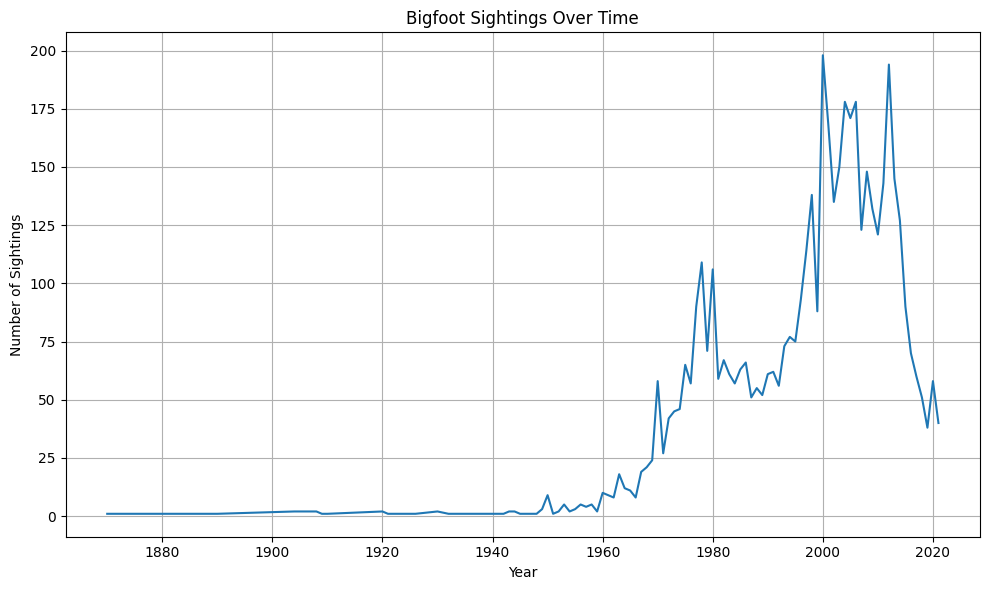

In [17]:
# Calculate number of bigfoot sightings by year
sightings_per_year = bigfoot_cleaned.groupby('Year').size()

# Plot the sightings per year on line graph
sightings_per_year.plot(
    kind='line',
    figsize=(10, 6),
    x=sightings_per_year.index,
    y=sightings_per_year.values,
    grid=True
).set(
    title='Bigfoot Sightings Over Time',
    xlabel='Year',
    ylabel='Number of Sightings'
)
plt.tight_layout()
plt.show()

Next, I want to visualize the sightings per state, to determine which has the most sightings. I decided to do this by plotting a choropleth map using geopandas. I needed to load in a url for the Natural Earth US States dataset, which has shape files for the map I'm creating. After separating the states as desired, and merging the geodataframes with my own, I also use the us library to create a dictionary of US state abbreviations to correlate with the state names. This way, I can annotate my maps after I've plotted them. 

Finally, I plot the US state map, with Alaska, Hawaii, and the New England states separated and inset, for better readability. (Of note, I have Hawaii's annotation on the screen but could not get the shape on the map. Unsure if this is an issue with the shape files, or something else, but I opted to still have it represented in the plot, even if just partially.)

C:\Users\camil\AppData\Local\Temp\ipykernel_27220\1877715367.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


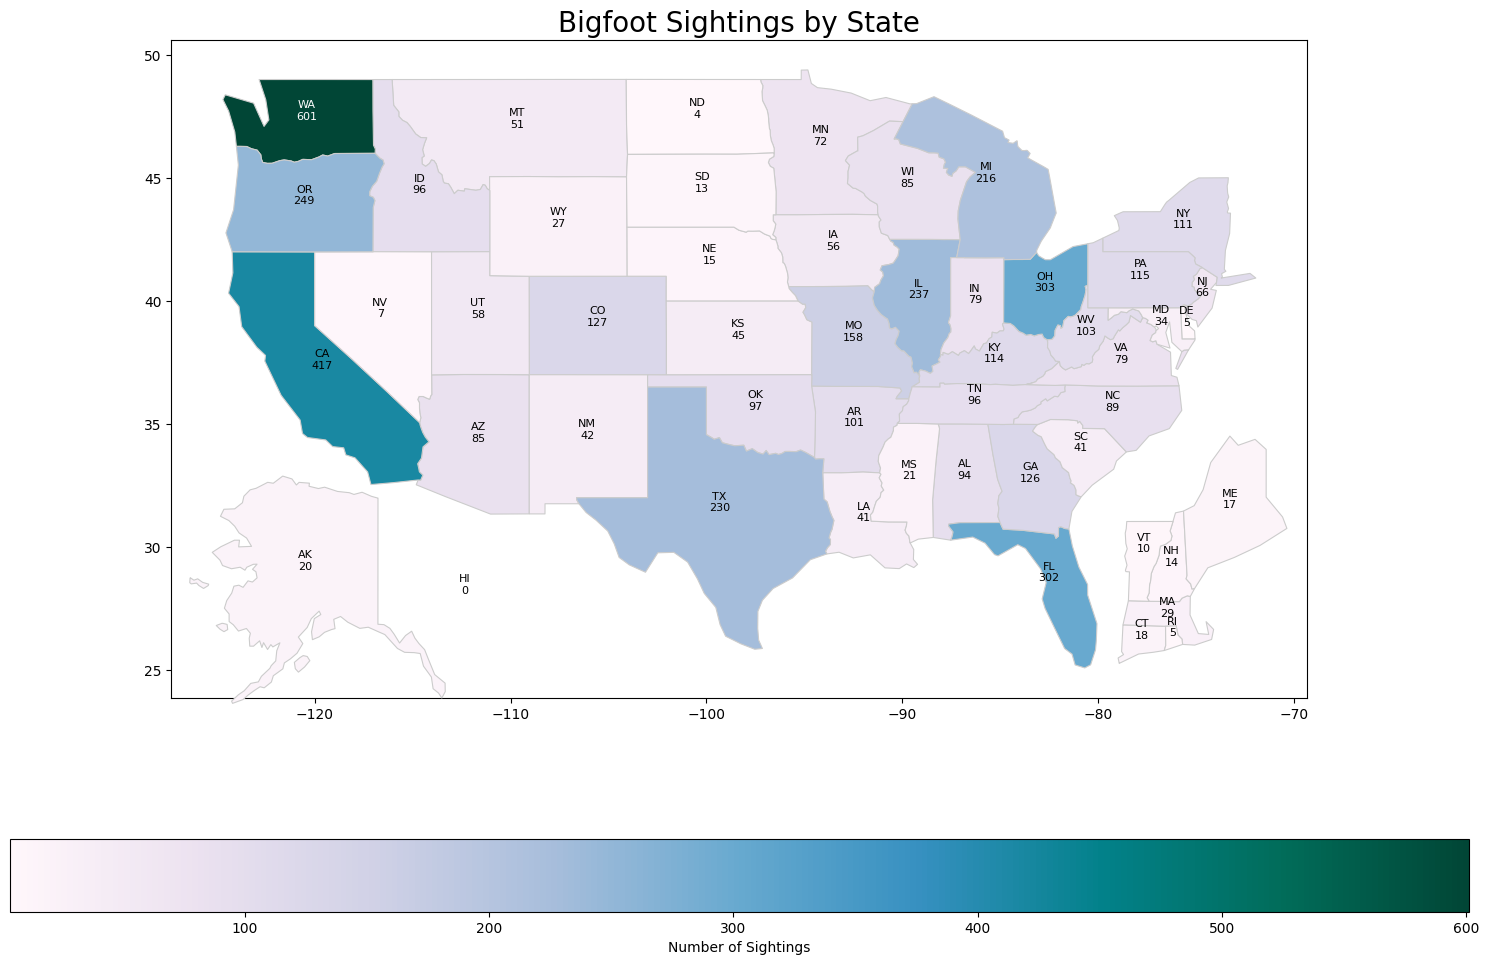

In [ ]:
# Load in URL for the Natural Earth US States dataset
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
us_states = gpd.read_file(url)

# Filter out D.C., Alaska, Hawaii, and the New England states
mainland_us = us_states[~us_states['name'].isin(['Alaska', 'Hawaii', 'District of Columbia', 'Maine', 'New Hampshire', 'Vermont', 'Rhode Island', 'Massachusetts', 'Connecticut'])]

# Separate Alaska, Hawaii and the New England states
alaska = us_states[us_states['name'] == 'Alaska']
hawaii = us_states[us_states['name'] == 'Hawaii']
new_england = us_states[us_states['name'].isin(['Maine', 'New Hampshire', 'Vermont', 'Rhode Island', 'Massachusetts', 'Connecticut'])]

# Find the total recorded sightings per state
sightings_per_state = bigfoot['State'].value_counts().reset_index()
sightings_per_state.columns = ['State', 'Sightings']
# Merge sightings per state data with the GeoDataFrames
mainland_us = mainland_us.set_index('name').join(sightings_per_state.set_index('State'))
alaska = alaska.set_index('name').join(sightings_per_state.set_index('State'))
hawaii = hawaii.set_index('name').join(sightings_per_state.set_index('State'))
new_england = new_england.set_index('name').join(sightings_per_state.set_index('State'))

# Create dictionary of State Abbreviations using the `us` library
state_abbreviations = {state.name: state.abbr for state in us.states.STATES}
# Use Normalize to ensure map colors are consistent across all plots
norm = Normalize(vmin=mainland_us['Sightings'].min(), vmax=mainland_us['Sightings'].max())

# Plot the mainland US excl. New England
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
mainland_us.plot(column='Sightings', cmap='PuBuGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                 legend_kwds={"label": "Number of Sightings", "orientation": "horizontal"}, norm=norm)
plt.title('Bigfoot Sightings by State', fontsize=20)

# Find the state with the highest amount of sightings
most_sightings = mainland_us['Sightings'].max()
# Annotate the mainland US map
for idx, row in mainland_us.iterrows():
    state_name = row.name
    sightings = int(row['Sightings']) if pd.notnull(row['Sightings']) else 0
    state_abbr = state_abbreviations.get(state_name, state_name)
    # Change most_sightings annotation text color to white for readability
    color = 'white' if sightings == most_sightings else 'black'
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
             f"{state_abbr}\n{sightings}", fontsize=8, color=color, ha='center', va='baseline')
# Create inset for Alaska
ax_inset1 = fig.add_axes([0.09, 0.28, 0.25, 0.25])
alaska.plot(column='Sightings', cmap='PuBuGn', linewidth=0.8, ax=ax_inset1, edgecolor='0.8', legend=False, norm=norm)
ax_inset1.axis('off')  

# Annotate Alaska inset
for idx, row in alaska.iterrows():
    state_name = row.name
    sightings = int(row['Sightings']) if pd.notnull(row['Sightings']) else 0
    state_abbr = state_abbreviations.get(state_name, state_name)
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
             f"{state_abbr}\n{sightings}", fontsize=8, color='black', ha='center')

# Create inset for Hawaii and adjust its position 
ax_inset2 = fig.add_axes([0.8, 0.3, 0.005, 0.005])  
hawaii.plot(column='Sightings', cmap='PuBuGn', linewidth=0.8, ax=ax_inset2, edgecolor='0.8', legend=False, norm=norm) 
ax_inset2.axis('off')

# Annotate Hawaii inset
for idx, row in hawaii.iterrows():
    state_name = row.name
    sightings = int(row['Sightings']) if pd.notnull(row['Sightings']) else 0
    state_abbr = state_abbreviations.get(state_name, state_name)
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
             f"{state_abbr}\n{sightings}", fontsize=8, color='black', ha='center')
# Create inset for New England states   
ax_inset3 = fig.add_axes([0.68, 0.32, 0.25, 0.25])
new_england.plot(column='Sightings', cmap='PuBuGn', linewidth=0.8, ax=ax_inset3, edgecolor='0.8', legend=False, norm=norm)
ax_inset3.axis('off')  

# Annotate New England inset
for idx, row in new_england.iterrows():
    state_name = row.name
    sightings = int(row['Sightings']) if pd.notnull(row['Sightings']) else 0
    state_abbr = state_abbreviations.get(state_name, state_name)
    plt.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
             f"{state_abbr}\n{sightings}", fontsize=8, color='black', ha='center', va='bottom')

plt.tight_layout()
plt.show()

So with the map created, we can see that Washington has the most sightings out of any state. I want to figure out what county within the state has the most sightings. To do this, I create a horizontal bar graphs of the top 10 counties in the state with the most sightings. 

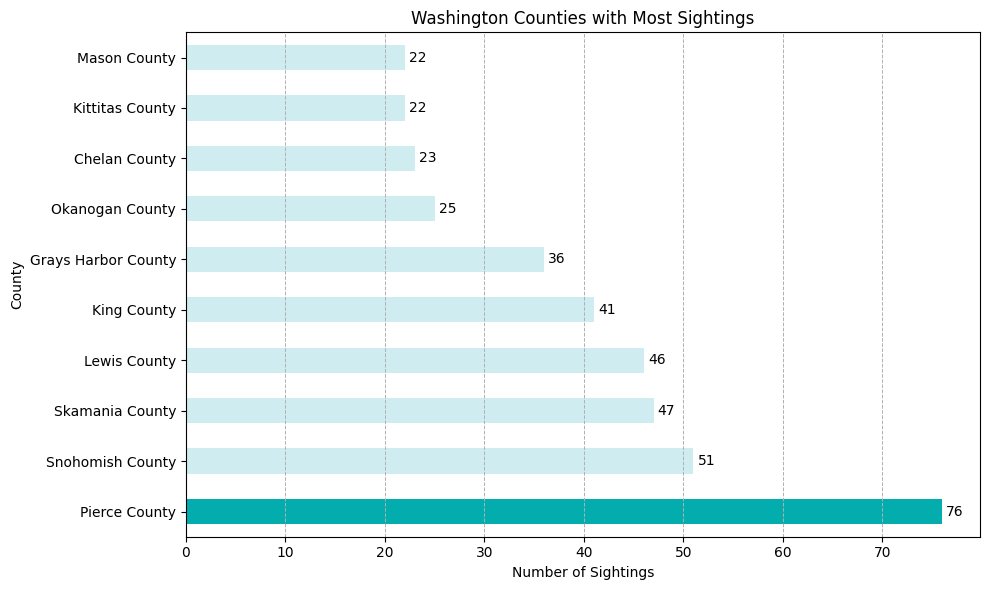

In [19]:
# Find State with most sightings
most_sightings_state = bigfoot_cleaned['State'].value_counts().idxmax()
# Filter dataframe to only show State with most sightings
top_state = bigfoot_cleaned[bigfoot_cleaned['State'] == most_sightings_state]

# Count the counties from top State, showing only highest 10 values
counties_head = top_state['County'].value_counts().head(10)
# Find the county with the most sightings
top_county = counties_head.idxmax()
# Colors to highlight county with most sightings 
colors = ['#03adae' if county == top_county else '#cfedf0' for county in counties_head.index]

# Plot horizontal bar graph
ax = counties_head.plot(
    kind='barh',
    color=colors,
    figsize=(10, 6),
    rot=0,
    title=f'{most_sightings_state} Counties with Most Sightings',
    xlabel='Number of Sightings',
    ylabel='County')
# Annotate graph
for bar in ax.patches:
    width = bar.get_width()
    ax.annotate(f'{int(width)}',
    xy=(width, bar.get_y() + bar.get_height() / 2),
    xytext=(3, 0),
    textcoords="offset points",
    ha='left', va='center')

plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

Now that I have visualizations for the where, I want to focus on when. To start off, I make a bar graph to display the total Bigfoot sightings per season.

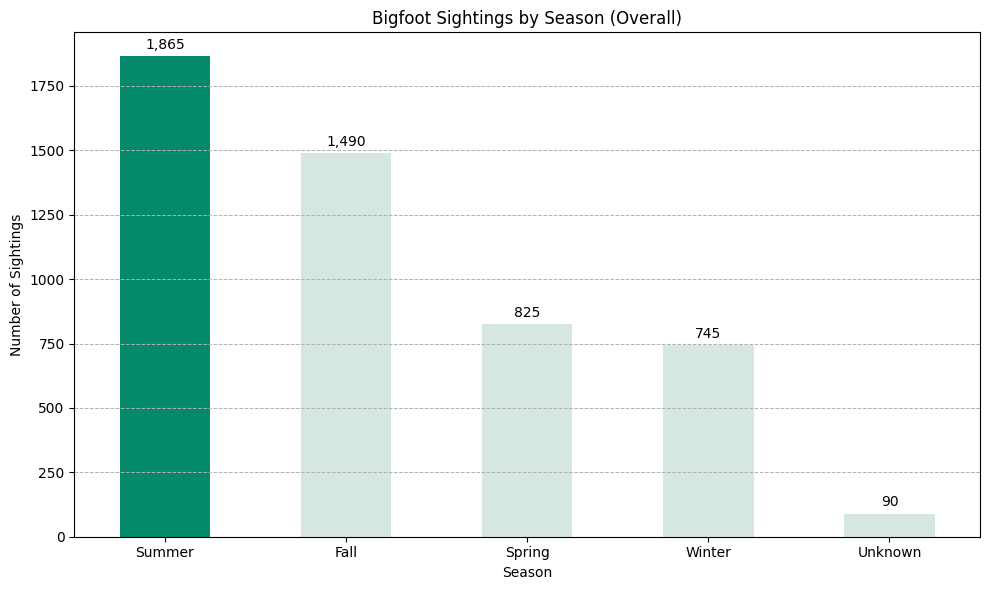

In [20]:
# Count the bigfoot sightings per season
sightings_per_season = bigfoot_cleaned['Season'].value_counts()
# Find the season with the most sightings
most_frequent_season = sightings_per_season.idxmax()
# Colors to highlight most frequent season
colors = ['#038a6b' if season == most_frequent_season else '#d6e6e2' for season in sightings_per_season.index]
# Create the bar graph
ax = sightings_per_season.plot(
    kind='bar',
    color=colors,
    figsize=(10, 6),
    rot=0,
    title='Bigfoot Sightings by Season (Overall)',
    xlabel='Season',
    ylabel='Number of Sightings')
# Annotate bar graph
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height()):,}',
    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
    xytext=(0, 3),
    textcoords="offset points",
    ha='center', va='bottom')

plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

With that created, I'm now curious how the numbers look if I look just at the sightings per season in the state with the most sightings. 

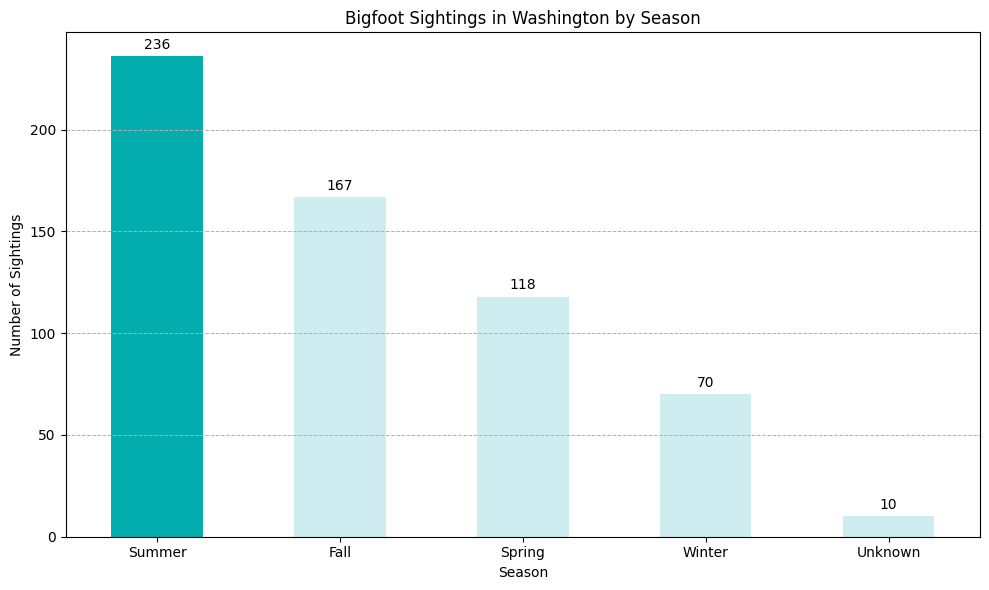

In [21]:
# Count the bigfoot sightings per season
sightings_per_season = top_state['Season'].value_counts()
# Find the season with the most sightings
most_frequent_season = sightings_per_season.idxmax()
# Colors to highlight most frequent season
colors = ['#03adae' if season == most_frequent_season else '#cfedf0' for season in sightings_per_season.index]
# Create the bar graph
ax = sightings_per_season.plot(
    kind='bar',
    color=colors,
    figsize=(10, 6),
    rot=0,
    title=f'Bigfoot Sightings in {most_sightings_state} by Season',
    xlabel='Season',
    ylabel='Number of Sightings')
# Annotate bar graph
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}',
    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
    xytext=(0, 3),
    textcoords="offset points",
    ha='center', va='bottom')

plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

I then do the same for the overall month with the most sightings.

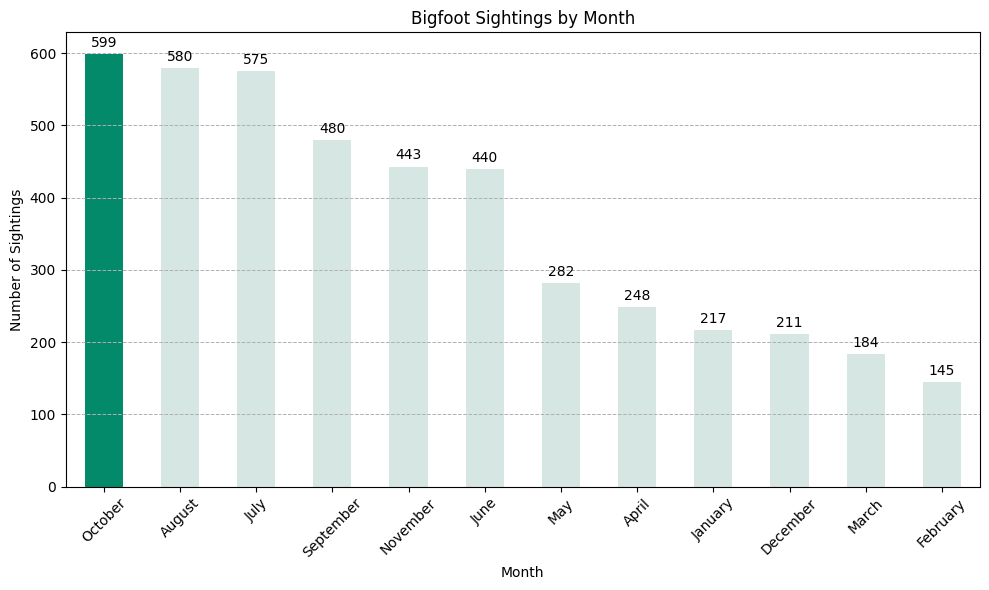

In [22]:
# Count sightings per month
sightings_per_month = month.value_counts('Month')
# Determine month with most sightings
most_frequent_month = sightings_per_month.idxmax()
# Colors to highlight most frequent month
colors = ['#038a6b' if month == most_frequent_month else '#d6e6e2' for month in sightings_per_month.index]

# Plot bar graph
ax = sightings_per_month.plot(
    kind='bar',
    color=colors,
    figsize=(10, 6),
    rot=0,
    stacked=True,
    title='Bigfoot Sightings by Month',
    xlabel='Month',
    ylabel='Number of Sightings')
# Annotate bar graph
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}',
    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
    xytext=(0, 3),
    textcoords="offset points",
    ha='center', va='bottom')
    
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

And then the month with the most sightings from the top state.

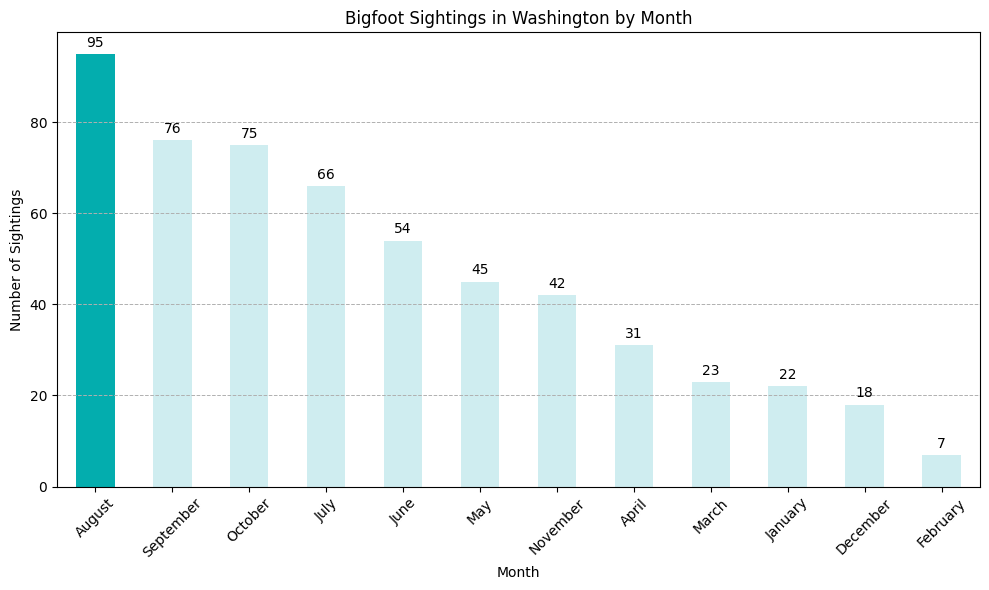

In [23]:
# Filter out null month values
top_state = top_state[top_state['Month'] != 'Unknown']
# Count sightings per month
sightings_per_month = top_state['Month'].value_counts()
# Determine month with most sightings
most_frequent_month = sightings_per_month.idxmax()
# Colors to highlight most frequent month
colors = ['#03adae' if month == most_frequent_month else '#cfedf0' for month in sightings_per_month.index]

# Plot bar graph
ax = sightings_per_month.plot(
    kind='bar',
    color=colors,
    figsize=(10, 6),
    rot=0,
    title=f'Bigfoot Sightings in {most_sightings_state} by Month',
    xlabel='Month',
    ylabel='Number of Sightings')
# Annotate bar graph
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}',
    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
    xytext=(0, 3),
    textcoords="offset points",
    ha='center', va='bottom')
    
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Finally, I plot the bar graph for which weekday overall has the most sightings, followed by a plot for the weekday with the most sightings in the top state. 

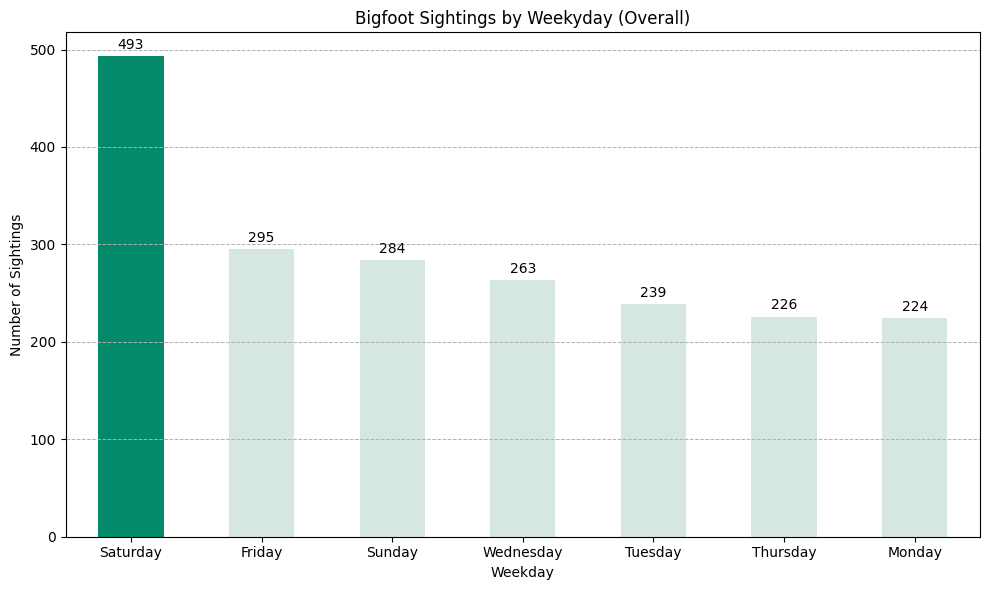

In [24]:
# Count sightings per weekday
sightings_per_weekday = bigfoot_cleaned['Weekday'].value_counts()
# Find weekday with most sightings
most_frequent_weekday = sightings_per_weekday.idxmax()
# Colors to highlight the most frequent weekday
colors = ['#038a6b' if weekday == most_frequent_weekday else '#d6e6e2' for weekday in sightings_per_weekday.index]

# Plot bar graph
ax = sightings_per_weekday.plot(
    kind='bar',
    color=colors,
    figsize=(10, 6),
    rot=0,
    title='Bigfoot Sightings by Weekyday (Overall)',
    xlabel='Weekday',
    ylabel='Number of Sightings')
# Annotate bar graph
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}',
    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
    xytext=(0, 3),
    textcoords="offset points",
    ha='center', va='bottom')

plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

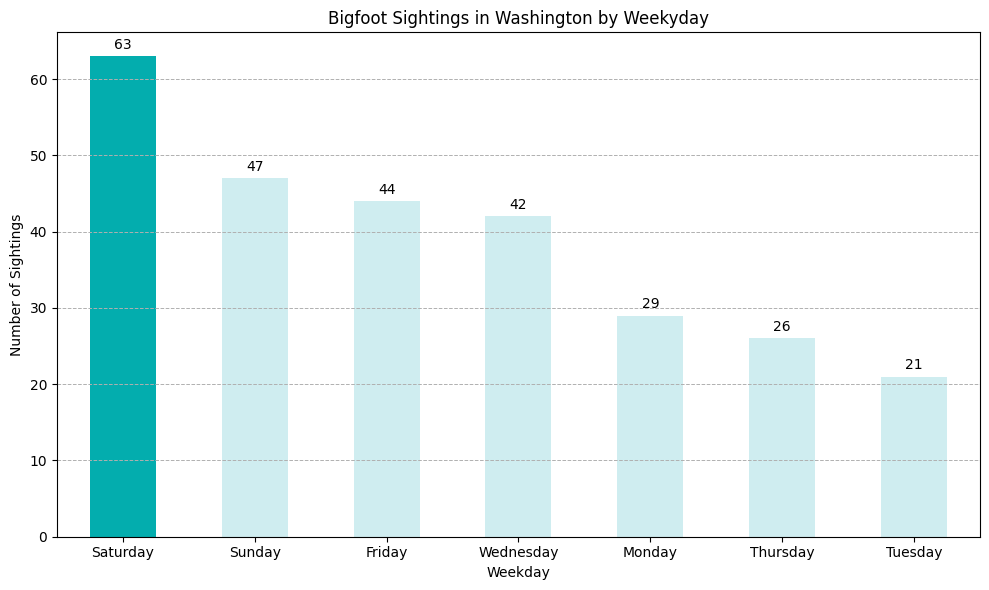

In [25]:
# Count sightings per weekday
sightings_per_weekday = top_state['Weekday'].value_counts()
# Find weekday with most sightings
most_frequent_weekday = sightings_per_weekday.idxmax()
# Colors to highlight the most frequent weekday
colors = ['#03adae' if weekday == most_frequent_weekday else '#cfedf0' for weekday in sightings_per_weekday.index]

# Plot bar graph
ax = sightings_per_weekday.plot(
    kind='bar',
    color=colors,
    figsize=(10, 6),
    rot=0,
    title=f'Bigfoot Sightings in {most_sightings_state} by Weekyday',
    xlabel='Weekday',
    ylabel='Number of Sightings')
# Annotate bar graph
for bar in ax.patches:
    ax.annotate(f'{int(bar.get_height())}',
    xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
    xytext=(0, 3),
    textcoords="offset points",
    ha='center', va='bottom')
    
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

## Analysis and Insights

#### Findings:
* There is an average of about 52 sightings reported per year.
* As shown by the line graph, reported sightings peaked in the year 2000 
* The state with the most sightings is Washington, with 601 reported sightings. 
* The least sightings occured in Hawaii, with 0 reported sightings. (I guess Bigfoot isn't big on vacations)
* In Washington, the most reported Bigfoot sightings occur in Pierce county. (Which makes sense as it encapsulates Mount Rainier National Park)
* The most Bigfoot sightings occur in the Summer, with a total of 1,865 reported sightings overall.
* The overall month with the most reported sightings is October, while in Washington the most sightings were in August. 
* Saturday's are the most common day for Bigfoot sightings, with 493 total recorded sightings and 63 recorded sightings in Washington alone. The weekend makes the top 3 days for sightings across both plots.

## Conclusions and Recommendations

Based on the above listed findings, we can conclude the most likely place to find Bigfoot is Washington state, specifically in the Pierce county area. Most sightings occur in the summer, with the best month to see Bigfoot in Washington based on reports being August. 

Further analysis could be done to see what trends in weather patterns and other environmental conditions effect the likliehood of seeing Bigfoot. I would also be interested to see how trends in outdoor activities in areas where sightings occur line up with reported sightings. 